## Food101 Practice NoteBook

Following notebooks uses **food101** data set from tensorflow datasets. This notebook shows the power of **transfer learning**. First a base model for tf.keras.applications is used for feature extraction and then some layers of the base model are fine tuned for food101 dataset.

In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds

tf.random.set_seed(42)

In [33]:
# check all the datasets in tensorflow_datasets
ds_list = tfds.list_builders()

# check if food101 is in the datasets
print(f"food101" in ds_list)

# load food101 data from tensorflow_datasets
(train_data, test_data), ds_info = tfds.load('food101',
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

True


In [34]:
# total samples in train and test data

len(train_data), len(test_data)

(75750, 25250)

In [35]:
# inspect ds_info and check class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

In [38]:
# inspect one instance of data
one_train_instance = train_data.take(1)

for image, label in one_train_instance:
    print(f"""
      Image dtype: {image.dtype}
      Image Shape: {image.shape}
      Label: {label}
      Label dtype: {label.dtype}
      Class Name: {class_names[label]}
      """)


      Image dtype: <dtype: 'uint8'>
      Image Shape: (512, 384, 3)
      Label: 74
      Label dtype: <dtype: 'int64'>
      Class Name: peking_duck
      


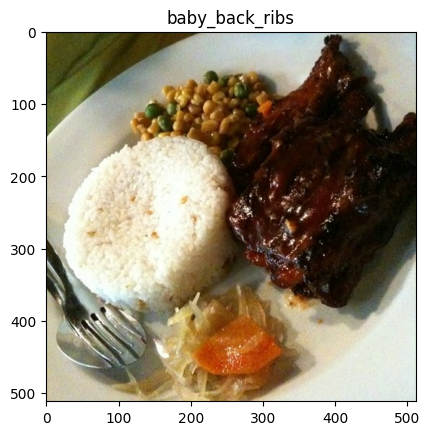

In [10]:
# check the image of one instance
one_train_instance = train_data.take(1)

for image, label in one_train_instance:
    plt.imshow(image)
    plt.title(f'{class_names[label]}')

In [11]:
# create global variable for image size
IMG_SIZE = 224

In [39]:
# function for data preprocessing
def preprocess_data(image, label, image_size=224):
    """
      Preprocesses an input image with a given label and returns the image after
      preprocessing and also its label.
      Changes its shape to [image_size, image_size, color_channels=3]
      Data type is changed to float32

      Args:
      image (tensor): input image
      label (str): image label
      image_size (int): required image size

      Return:
      image (tensor): output image after preprocessing
    """
    image = tf.image.resize(image, [image_size, image_size])
    return tf.cast(image, tf.float32), label

In [13]:
# function for viewing an image and its label

def view_image(image, label):
    """
    Shows the image along with its label.
    
    Args:
    image (np.array): input image
    label (str): image label
    """
    for image, label in one_train_instance:
        print(f'shape of image: {image.shape}')
        plt.imshow(image)
        plt.title(f'{class_names[label]}')

shape before preprocessing: (512, 512, 3)
shape after preprocessing: (224, 224, 3)


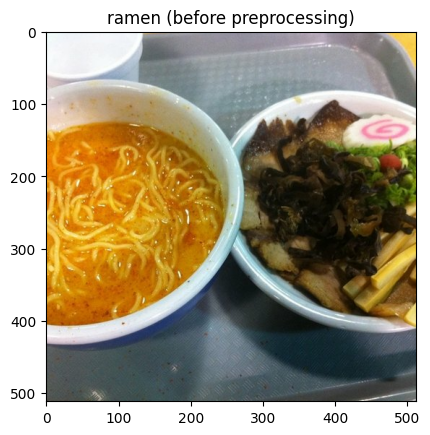

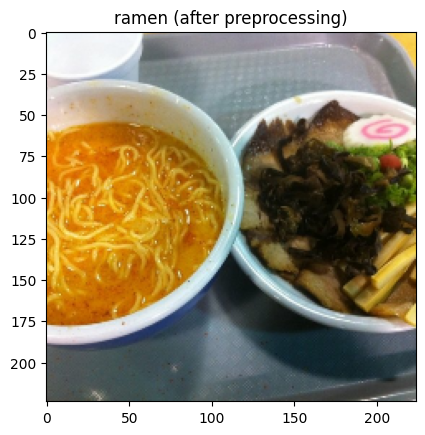

In [15]:
# preprocess one instance to check if preprocess_data is working fine
one_train_instance = train_data.take(1)

for image, label in one_train_instance:
    print(f'shape before preprocessing: {image.shape}')
    plt.imshow(image)
    plt.title(f'{class_names[label]} (before preprocessing)')

    image, label = preprocess_data(image, label)
    plt.figure()
    print(f'shape after preprocessing: {image.shape}')
    plt.imshow(image/255.)
    plt.title(f'{class_names[label]} (after preprocessing)')

In [17]:
# # create a data augmentation layer

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomHeight(0.2),
#     tf.keras.layers.RandomWidth(0.2),
#     tf.keras.layers.RandomZoom(0.2),
# ], name="data_augmentation_layer")

In [18]:
# # make a function for data augmentation
# def augment_data(image, label):
#     image = data_augmentation(image, training=True)  # Apply data augmentation here
#     return image, label

In [40]:
# prepare the 10% of data for feature extraction
# prepare training data
tf.random.set_seed(42)

train_data_10 = train_data.shuffle(buffer_size=1000).take(int(0.1*len(train_data)))
train_data_10 = train_data_10.map(preprocess_data,
                                  num_parallel_calls=tf.data.AUTOTUNE) # preprocess the data, use num_parallel_pr... to use all resources available
# train_data_10 = train_data_10.map(augment_data,
#                                   num_parallel_calls=tf.data.AUTOTUNE) # data augmentation
train_data_10 = train_data_10.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # shuffle, make batches of data, use prefetch for faster processing

#  prepare test data
test_data_10 = test_data.map(preprocess_data,
                             num_parallel_calls=tf.data.AUTOTUNE)
test_data_10 = test_data_10.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

len(train_data_10), len(test_data_10)

(237, 790)

In [ ]:
# prepare the 10% of data for feature extraction
# prepare training data
tf.random.set_seed(42)

train_data_20 = train_data.shuffle(buffer_size=1000).take(int(0.2*len(train_data)))
train_data_20 = train_data_20.map(preprocess_data,
                                  num_parallel_calls=tf.data.AUTOTUNE) # preprocess the data, use num_parallel_pr... to use all resources available
# train_data_10 = train_data_10.map(augment_data,
#                                   num_parallel_calls=tf.data.AUTOTUNE) # data augmentation
train_data_20 = train_data_20.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # shuffle, make batches of data, use prefetch for faster processing

#  prepare test data
test_data_20 = test_data.map(preprocess_data,
                             num_parallel_calls=tf.data.AUTOTUNE)
test_data_20 = test_data_20.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

len(train_data_20), len(test_data_20)

In [22]:
train_data_10

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [41]:
# prepare the data for model building and training
# prepare training data
tf.random.set_seed(42)

train_data_full = train_data.map(preprocess_data,
                                 num_parallel_calls=tf.data.AUTOTUNE) # preprocess the data, use num_parallel_pr... to use all resources available
train_data_full = train_data_full.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # shuffle, make batches of data, use prefetch for faster processing

#  prepare test data
test_data_full = test_data.map(preprocess_data,
                               num_parallel_calls=tf.data.AUTOTUNE)
test_data_full = test_data_full.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

len(train_data_full), len(test_data_full)

(2368, 790)

In [20]:
train_data_full, test_data_full

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [16]:
len(train_data), len(test_data)

(2368, 790)

In [27]:
# create checkpoints to save model weights

checkpoint_path = "/kaggle/working/food101_checkpoints/feature_extraction/model_1.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_loss",
#                                                          save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

In [189]:
# file_path = "/kaggle/working/food101_checkpoints/feature_extraction/model_1.keras"
# if os.path.exists(file_path):
#     os.remove(file_path)

# import shutil
# directory_path = "/kaggle/working/food101_checkpoints/feature_extraction"
# if os.path.exists(directory_path):
#     shutil.rmtree(directory_path)

In [7]:
# use mixed precision for fast model training
import tensorflow as tf
from tensorflow.keras import mixed_precision

# set global policy to "mixed_float16": use float16 for computations and float32 for storing
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [42]:
# create a function for building models using a specific base_model 

def build_model_using_pretrained_base_model(base_model, model_name, input_shape=224):
    """
    Builds a model using given base_model as base.
    
    Args:
    ----
    base_model (tf.keras.applications.---): base model
    model_name (str): name of model
    input_shape (int): image size
    
    Return:
    ------
    model (tf.keras.Model): returns an instance of model
    """
    
    base_model = base_model
    base_model.trainable = False # set all the layers to be not trainable

    inputs = tf.keras.layers.Input(shape=(input_shape, input_shape, 3), name="input_layer")

    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = tf.keras.layers.Dense(len(class_names))(x)

    # use softmax as separate activation layer, so that the output dtype can be explicitly set to float32 for higher precision
    outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="output_layer")(x)

    model = tf.keras.Model(inputs, outputs, name=model_name)

    model.compile(loss='sparse_categorical_crossentropy', # target classes have been label encoded
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    model.summary()
    
    return model
    

In [43]:
# create a helper function for plotting history of model
import seaborn as sns
def plot_model_history(history):
    """
        Plots the loss and accuracy of given model history.
        
        Args:
        history (object): contains training/test loss and accuracy
    """
    
    sns.lineplot(x=history.epoch, y=history.history["loss"], label="Training Loss")
    sns.lineplot(x=history.epoch, y=history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curves")
    plt.legend()
    
    plt.figure()
    sns.lineplot(x=history.epoch, y=history.history["accuracy"], label="Training Accuracy")
    sns.lineplot(x=history.epoch, y=history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Accuracy Curves")
    plt.legend();

In [23]:
# # build and compile the model

# tf.random.set_seed(42)

# IMG_SIZE = 224

# # use EfficientNetB0 model from tf.keras.applications as the base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False) # do not include the top output layer
# base_model.trainable = False # set all the layers to be not trainable

# inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_layer")

# # x = data_augmentation(inputs)

# x = base_model(inputs, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = tf.keras.layers.Dense(len(class_names))(x)

# # use softmax as separate activation layer, so that the output dtype can be explicitly set to float32 for higher precision
# outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="output_layer")(x)

# model_effb0_feat_etract_10 = tf.keras.Model(inputs, outputs, name="food101_model_using_efficientnetb0")

# model_effb0_feat_etract_10.compile(loss='sparse_categorical_crossentropy', # target classes have been label encoded
#                                    optimizer=tf.keras.optimizers.Adam(),
#                                    metrics=['accuracy'])

In [9]:
# model_effb0_feat_etract_10.summary()

In [58]:
# use EfficientnetB0 as base model for feature extraction

tf.random.set_seed(42)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
model_name = "food101_feat_etract_effb0_20_pct_data"
model_effb0_feat_etract_20 = build_model_using_pretrained_base_model(base_model, model_name, input_shape=224)

Model: "food101_feat_etract_effb0_20_pct_data"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Activation)       │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [59]:
# check the trainable parameter of all the layers

for layer in model_effb0_feat_etract_20.layers:
    print(f"{layer.name}, is trainable={layer.trainable}")

input_layer, is trainable=True
efficientnetb0, is trainable=False
pooling_layer, is trainable=True
dense_4, is trainable=True
output_layer, is trainable=True


In [74]:
# check trainable parameter of all layers of base model in model_effb0.layers[1]

# for layer in model_effb0.layers[1].layers:
#     print(f"{layer.name}, is trainable={layer.trainable}")

In [60]:
# check mixed precision policy for all layers

for layer in model_effb0_feat_etract_20.layers:
    print(f"{layer.name}, {layer.dtype}, {layer.dtype_policy}")

input_layer, float32, <DTypePolicy "mixed_float16">
efficientnetb0, float32, <DTypePolicy "mixed_float16">
pooling_layer, float32, <DTypePolicy "mixed_float16">
dense_4, float32, <DTypePolicy "mixed_float16">
output_layer, float32, <DTypePolicy "float32">


In [61]:
# train the model for feature extraction
initial_epochs = 5

history_model_effb0_20_pct = model_effb0_feat_etract_20.fit(train_data_20,
                                                            epochs=initial_epochs,
                                    #                        steps_per_epoch=len(train_data),
                                                            validation_data=test_data_20,
                                                            validation_steps=int(0.15*len(test_data_20)),
                #                                            callbacks=[checkpoint_callback],
                                                            verbose=1)


Epoch 1/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.2610 - loss: 3.4172 - val_accuracy: 0.5479 - val_loss: 1.8485
Epoch 2/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.5299 - loss: 1.9276 - val_accuracy: 0.6028 - val_loss: 1.5681
Epoch 3/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.5955 - loss: 1.6261 - val_accuracy: 0.6163 - val_loss: 1.4626
Epoch 4/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6028 - loss: 1.5518 - val_accuracy: 0.6457 - val_loss: 1.3710
Epoch 5/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6373 - loss: 1.4262 - val_accuracy: 0.6425 - val_loss: 1.3431


In [62]:
# evaluate the model on whole test set

results_model_effb0_20_pct = model_effb0_feat_etract_20.evaluate(test_data_20)
results_model_effb0_20_pct

790/790 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.6409 - loss: 1.3531


[1.3450032472610474, 0.6446336507797241]

In [63]:
model_effb0_feat_etract_20.save("/kaggle/working/model_effb0_feat_etract_20pct_5_ep.keras")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

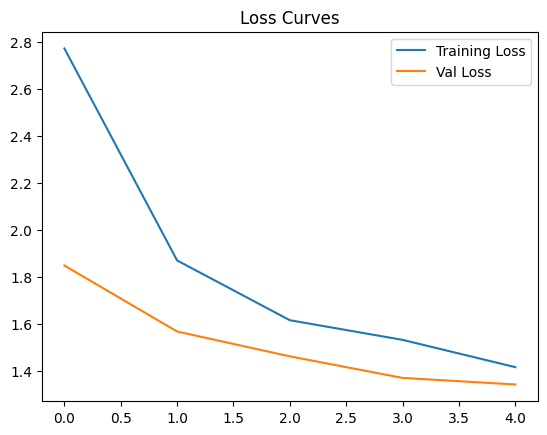

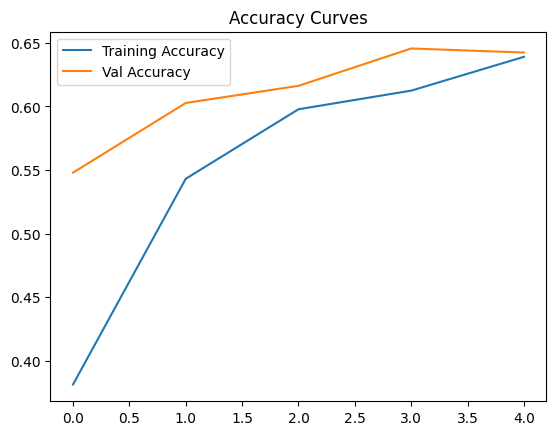

In [64]:
# use helper function to plot loss and accuracy curves

plot_model_history(history_model_effb0_20_pct)

In [196]:
# make model checkpoitnt callback, 
# early stopping callback and ReduceLROnPlateau callback for fine tuning the model

fine_tune_checkpoint_path = "/kaggle/working/food101_checkpoints/fine_model_1_aug.keras"
fine_tune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(fine_tune_checkpoint_path,
                                                                monitor='val_loss',
                                                                save_freq='epoch',
                                                                save_best_only=True,
                                                                verbose=1)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                          patience=3)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=0.2,
                                                   patience=2,
                                                   verbose=1,
                                                   min_lr=1.0e-7)

In [197]:
# load previously saved feature extraction model

loaded_model_1 = tf.keras.models.load_model("/kaggle/working/food101_checkpoints/feature_extraction/model_1.keras")
loaded_model_1.summary()

Model: "food101_model_using_efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Activation)       │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [198]:
loaded_model_1_results = loaded_model_1.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.6975 - loss: 1.1149


In [199]:
# check what layers of the loaded model are trainable

for layer in loaded_model_1.layers:
    print(f"{layer.name} is trainable: {layer.trainable}")

input_layer is trainable: True
efficientnetb0 is trainable: False
pooling_layer is trainable: True
dense_10 is trainable: True
output_layer is trainable: True


In [155]:
# check what layers of base model in loaded model are trainable
# for layer in loaded_model_1.layers[2].layers:
#     print(f"{layer.name} is trainable: {layer.trainable}")

In [153]:
loaded_model_1.layers[2].layers[-10:]

[<GlobalAveragePooling2D name=block7a_se_squeeze, built=True>,
 <Reshape name=block7a_se_reshape, built=True>,
 <Conv2D name=block7a_se_reduce, built=True>,
 <Conv2D name=block7a_se_expand, built=True>,
 <Multiply name=block7a_se_excite, built=True>,
 <Conv2D name=block7a_project_conv, built=True>,
 <BatchNormalization name=block7a_project_bn, built=True>,
 <Conv2D name=top_conv, built=True>,
 <BatchNormalization name=top_bn, built=True>,
 <Activation name=top_activation, built=True>]

In [201]:
# make all layers of base model of loaded model as trainable

for layer in loaded_model_1.layers[1].layers:
    layer.trainable = True

In [204]:
# for layer in loaded_model_1.layers[1].layers:
#     print(f"After: {layer.name} is trainable: {layer.trainable}")

In [205]:
# compile the loaded model

loaded_model_1.compile(loss="sparse_categorical_crossentropy", 
                       optimizer=tf.keras.optimizers.Adam(0.0001), 
                       metrics=["accuracy"])

In [206]:
# check tf mixed precision

for layer in loaded_model_1.layers:
    print(f"{layer.name}, {layer.dtype}, {layer.dtype_policy}")


input_layer, float32, <DTypePolicy "mixed_float16">
efficientnetb0, float32, <DTypePolicy "mixed_float16">
pooling_layer, float32, <DTypePolicy "mixed_float16">
dense_10, float32, <DTypePolicy "mixed_float16">
output_layer, float32, <DTypePolicy "float32">


In [207]:
# fine tune the loaded model

history_1_loaded = loaded_model_1.fit(train_data,
                                      epochs=100,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      callbacks=[earlystopping_callback,
                                                 lr_callback,
                                                 fine_tune_model_checkpoint])

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6189 - loss: 1.4979
Epoch 1: val_loss improved from inf to 0.74015, saving model to /kaggle/working/food101_checkpoints/fine_model_1_aug.keras
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 412s 122ms/step - accuracy: 0.6190 - loss: 1.4977 - val_accuracy: 0.7913 - val_loss: 0.7402 - learning_rate: 1.0000e-04
Epoch 2/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7964 - loss: 0.7559
Epoch 2: val_loss improved from 0.74015 to 0.69787, saving model to /kaggle/working/food101_checkpoints/fine_model_1_aug.keras
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 212s 89ms/step - accuracy: 0.7964 - loss: 0.7559 - val_accuracy: 0.8067 - val_loss: 0.6979 - learning_rate: 1.0000e-04
Epoch 3/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8589 - loss: 0.5281
Epoch 3: val_loss improved from 0.69787 to 0.63874, saving model to /kaggle/working/food101_checkpoints/fine_model_1_aug.keras
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 211s 89ms/step - acc

In [209]:
# evaluate the fine tuned model on whole test data

loaded_model_1_results = loaded_model_1.evaluate(test_data)
loaded_model_1_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8325 - loss: 0.6363


[0.6397926807403564, 0.8312475085258484]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

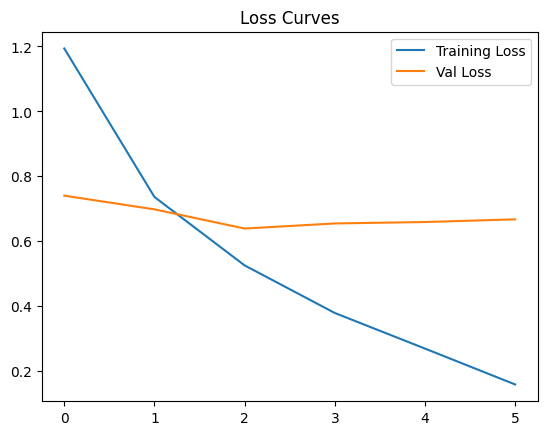

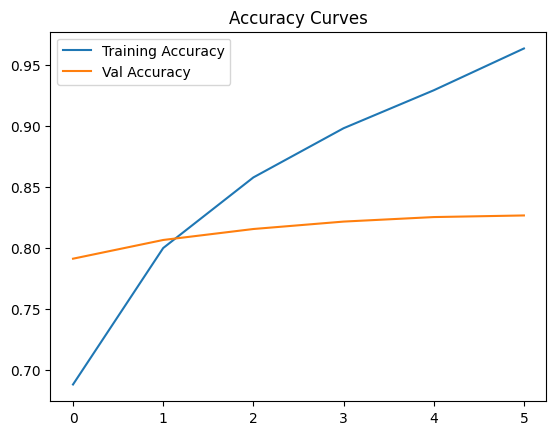

In [210]:
# plot training/test loss and accuracy
plot_model_history(history_1_loaded)


In [45]:
# use mixed precision for fast model training
import tensorflow as tf
from tensorflow.keras import mixed_precision

# set global policy to "mixed_float16": use float16 for computations and float32 for storing
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [52]:
# use EfficientnetB7 as base model for feature extraction

tf.random.set_seed(42)

base_model = tf.keras.applications.EfficientNetB7(include_top=False)
model_name = "food101_feat_etract_effb7_20_pct_data"
model_effb7_feat_extract_20_pct = build_model_using_pretrained_base_model(base_model, 
                                                                          model_name, 
                                                                          input_shape=224)

Model: "food101_feat_etract_effb7_20_pct_data"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │       258,661 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Activation)       │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,356,348 (245.50 MB)

 Trainable params: 258,661 (1010.39 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [53]:
for layer in model_effb7_feat_extract_20_pct.layers:
    print(layer.dtype_policy)

<DTypePolicy "mixed_float16">
<DTypePolicy "mixed_float16">
<DTypePolicy "mixed_float16">
<DTypePolicy "mixed_float16">
<DTypePolicy "float32">


In [54]:
# train the model using preprocessed train data

initial_epochs = 5
history_effb7_feat_extract_20 = model_effb7_feat_extract_20_pct.fit(train_data_20,
                                                                 epochs=initial_epochs,
                                                                 validation_data=test_data_20,
                                                                 validation_steps=int(0.15*len(test_data_20)))

Epoch 1/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 322s 400ms/step - accuracy: 0.2822 - loss: 3.2454 - val_accuracy: 0.5381 - val_loss: 1.8291
Epoch 2/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 67s 139ms/step - accuracy: 0.5200 - loss: 1.9308 - val_accuracy: 0.5832 - val_loss: 1.6073
Epoch 3/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.5716 - loss: 1.7101 - val_accuracy: 0.6038 - val_loss: 1.5088
Epoch 4/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.5966 - loss: 1.5907 - val_accuracy: 0.6075 - val_loss: 1.4791
Epoch 5/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.6245 - loss: 1.4737 - val_accuracy: 0.6205 - val_loss: 1.4285


In [55]:
model_effb7_feat_extract_20_pct.evaluate(test_data_20)

790/790 ━━━━━━━━━━━━━━━━━━━━ 94s 118ms/step - accuracy: 0.6211 - loss: 1.4426


[1.4429701566696167, 0.6214257478713989]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

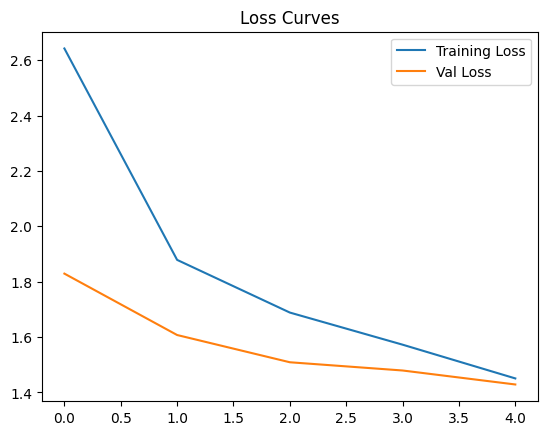

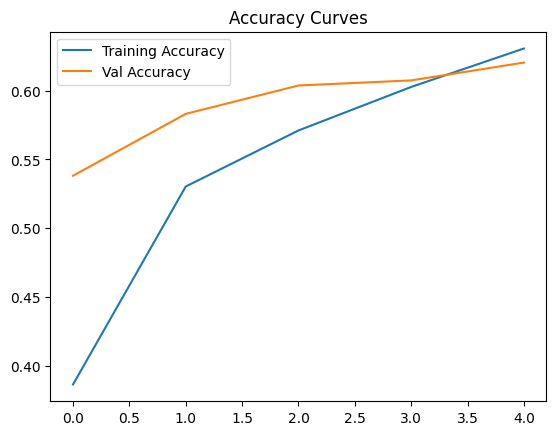

In [57]:
# plot training/test loss and accuracy
plot_model_history(history_effb7_feat_extract_20)

In [56]:
model_effb7_feat_extract_10_pct.save("/kaggle/working/model_effb7_feat_extract_20_pct_5_ep.keras")